In [6]:
import os
import csv
import struct
import chardet
import numpy as np
import collections
import pandas as pd
from typing import *
from time import time
import seaborn as sns
from sklearn.svm import SVC
from skimage.feature import hog
from numpy import random as rnd
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot
from sklearn.utils import shuffle
import matplotlib.font_manager as fm
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from IPython.display import clear_output
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

In [2]:
!ls

Compare_sklearn_scaler_v1.ipynb README.md
Logistic Regression.ipynb       SVM.ipynb
NHIS_OPEN_GJ_2017_100.csv       cache
NHIS_OPEN_GJ_2018_100.csv


# Data Reading

In [75]:
class ReadData():
    def __init__(self, selected_features, year=2017, special_features=None):
        self.year = year
        self.infos = []
        self.data = []
        self.labels = []
        self.no_data = []
        self.data_infos = []
        self.selected_features = selected_features
        self.required_info_index = []
        self.no_data_count = collections.defaultdict(int)
        self.get_features_index()
        self.X = None
        self.y = None
        
    def read(self, DATASIZE=None, FBS_PIVOT=120, calculate_BMI=True, return_data=True):
        year = self.year
        print(f'Reading year {self.year}')
        if not DATASIZE:
            DATASIZE = float('inf')
        if year == 2017:
            FILENAME = 'NHIS_OPEN_GJ_2017_100.csv'
        elif year == 2018:
            FILENAME = 'NHIS_OPEN_GJ_2018_100.csv'
        else:
            raise Exception('year should be 2017 or 2018. default=2017')
            
        
        with open(FILENAME, 'rb') as f:
            ENCODING = chardet.detect(f.readline())['encoding']
            
        f = open(FILENAME, 'r', encoding=ENCODING)
        rdr = csv.reader(f)
        
        required_info_index = self.required_info_index

        for n, col in enumerate(rdr):
            required_data = [info for index, info in enumerate(col) if index in required_info_index]
            if n == 0:
                self.infos.append(col)
                self.infos = self.infos[0]
                self.data_infos.append(required_data)
                self.data_infos = self.data_infos[0]
                FBS_INDEX = self.infos.index('식전혈당(공복혈당)')
                
                if calculate_BMI:
                    if '신장(5Cm단위)' not in self.data_infos or '체중(5Kg단위)' not in self.data_infos:
                        calculate_BMI = False
                    else:
                        HEIGHT_INDEX, WEIGHT_INDEX = self.data_infos.index('신장(5Cm단위)'), self.data_infos.index('체중(5Kg단위)')
                        if WEIGHT_INDEX < HEIGHT_INDEX:
                            raise Exception('selected_features에서 신장을 체중보다 먼저 오도록 설정해주세요.')
                        self.data_infos.append('BMI')
            else:
                FBS = col[FBS_INDEX]
                if '' in required_data or FBS == '':
#                     print(required_data)
#                     print(self.data_infos)
                    l = [self.data_infos[i] for i, d in enumerate(required_data) if d == '']
                    for s in l: self.no_data_count[s] += 1
                    self.no_data.append(n)
                else:
                    if calculate_BMI:
                        height, weight = int(required_data.pop(HEIGHT_INDEX)), int(required_data.pop(WEIGHT_INDEX-1))
                        BMI = round(weight / (height * height / 10000), 2)
                        required_data.append(BMI)
#                     try:
#                         if max(map(int, required_data)) > 1000:  # hard filtering
#                             continue
#                     except:
#                         print(required_data)
#                     if intensity:
#                         for pivot_i, i in enumerate(special_features_index):
#                             if required_data[i] < special_features_pivot[pivot_i]:
# #                                 required_data[i] 
#                                 pass
#                     arr = [val for val in required_data[:-1]]
                    
                    self.data.append(required_data)
                    self.labels.append(1) if int(FBS) >= FBS_PIVOT else self.labels.append(0)
                    
            if n >= DATASIZE:
                break

        f.close()
        if calculate_BMI:
            self.data_infos.pop(HEIGHT_INDEX)
            self.data_infos.pop(WEIGHT_INDEX-1)
        X = np.array(self.data)
        X = X.astype(np.float64)
        y = np.array(self.labels)
        
        print(f"Reading year {year}'s data done")
        print(f'Size of X = {len(X)}, y = {len(y)}')
        print(f'당뇨병 판별 공복혈당 기준 수치 : {FBS_PIVOT}')
        counts = np.unique(y, return_counts = True)[1]
        print(f'당뇨병 판별 환자 수 : {counts[1]}, 비당뇨병 판별수 : {counts[0]}\n')
        print(f'X has {X.shape[1]} features')
        print(f'Size of data with empty value = {len(self.no_data)}')
        print(f'Selected Features and Sample Data: \n{self.data_infos}\n{X[0]}\n{X[1]}')
        self.X, self.y = [X, y]
        if return_data:
            return [X, y]
    
    def get_features_index(self):
        df = default_features()
        for feature in self.selected_features:
            if feature not in df:
                raise Exception(f"'{feature}'는 데이터에 없습니다.")
            self.required_info_index.append(df.index(feature))
        self.required_info_index.sort()

# Read Data

In [82]:
# obj = ReadData(selected_features=features_index, year=2017 or 2018)
selected_features = ['트리글리세라이드', 'LDL콜레스테롤', '신장(5Cm단위)', '체중(5Kg단위)']
data2017 = ReadData(selected_features, year=2017)
# X, y = obj.read(calculate_BMI = 체중, 키를 BMI지수로 환산, FBS_PIVOT =  당노병 판단 기준 혈당)
X, y = data2017.read(calculate_BMI=True, FBS_PIVOT=140, DATASIZE=1000, return_data=True)
# data2017.read(calculate_BMI=True, FBS_PIVOT=140, DATASIZE=1000, return_data=False)

Reading year 2017
Reading year 2017's data done
Size of X = 997, y = 997
당뇨병 판별 공복혈당 기준 수치 : 140
당뇨병 판별 환자 수 : 44, 비당뇨병 판별수 : 953

X has 3 features
Size of data with empty value = 3
Selected Features and Sample Data: 
['트리글리세라이드', 'LDL콜레스테롤', 'BMI']
[ 92.   126.    25.95]
[121.   148.    24.69]


# Grid Search Features

In [ ]:
grid_features = ['트리글리세라이드', '총콜레스테롤', 'LDL콜레스테롤', '허리둘레', 
                 '감마지티피', '혈색소', '허리둘레', '(혈청지오티)ALT', '(혈청지오티)AST']
hw = ['신장(5Cm단위)', '체중(5Kg단위)']


# Default Features

In [23]:
def default_features():
    features = ['기준년도', '가입자일련번호', '성별코드', '연령대코드(5세단위)', '시도코드',
                '신장(5Cm단위)', '체중(5Kg단위)', '허리둘레', '시력(좌)', '시력(우)',
                '청력(좌)', '청력(우)', '수축기혈압', '이완기혈압', '식전혈당(공복혈당)',
                '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', 
                '요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피',
                '흡연상태', '음주여부', '구강검진수검여부', '치아우식증유무', '결손치유무',
                '치아마모증유무', '제3대구치(사랑니)이상', '치석', '데이터공개일자']
    return features

In [ ]:
dict(data2017.no_data_count)

In [6]:
# obj = ReadData(year=2017 or 2018, required_info_index = features_index)
data2018 = ReadData(year=2018, required_info_index = features_index)
# X, y = obj.read(calculate_BMI = 체중, 키를 BMI지수로 환산, FBS_PIVOT =  당노병 판단 기준 혈당)
X, y = data2018.read(calculate_BMI=True, FBS_PIVOT=140)
clear_output()
dict(data2018.no_data_count)

{'총콜레스테롤': 667244,
 '트리글리세라이드': 667252,
 'HDL콜레스테롤': 667254,
 'LDL콜레스테롤': 674122,
 '음주여부': 354943,
 '요단백': 10570,
 '수축기혈압': 5730,
 '이완기혈압': 5730,
 '혈색소': 5914,
 '혈청크레아티닌': 5906,
 '(혈청지오티)AST': 5906,
 '(혈청지오티)ALT': 5906,
 '감마지티피': 5909,
 '허리둘레': 414,
 '흡연상태': 234}

# Scaling

In [4]:
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X[:])
def scale_robust(X_train, X_test):
    robustScaler = RobustScaler()
    robustScaler.fit(X_train[:])
    X_train = robustScaler.transform(X_train[:])
    X_test = robustScaler.transform(X_test[:])
    print(f'Sample Scaled Data : {X_train[0]}')
    return [X_train[:], X_test[:]]

# Split Training, Test Set
(If required)

In [6]:
def split_set(X, y):
    # X_train, X_test, y_train, y_test
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Reset Labels with new FBS Pivot

In [16]:
def reset_fbs(fbs:int, year):
    read_new = ReadData(year=year)
    X, y = read_new.read(FBS_PIVOT=fbs)
    return [X,y]

# Logistic Regression

In [21]:
class DiabetesModelingLR():
    def __init__(self, X=None, y=None):
        self.X = X
        self.y = y
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.clf = None
        self.training_size = None
        self.testing_size = None
        self.CROSSVAL=False
        self.SPLIT_DATA = True
        self.RESET_FBS = False
        self.SCALE = True
    def LR(self):
        intensity = True
        X, y = self.X, self.y
        if self.RESET_FBS:
            FBS = 120
            year = 2017
            X, y = reset_fbs(fbs=FBS, year=year)
        if self.SPLIT_DATA:
            X_train, X_test, y_train, y_test = split_set(X, y)
            self.X_train, self.X_test, self.y_train, self.y_test = [
                X_train, X_test, y_train, y_test]
        if X_train.shape[1] != X_test.shape[1]:
            raise Exception('Training Set과 Test Set의 Feature가 다릅니다.')
        if self.SCALE:
            X_train, X_test = scale_robust(X_train, X_test)
            
#         if intensity:
#             for i in range(0, len(X_train)):
#                 for j in range(0, len(X_train[0])):
#                     if X_train[i][j] <= 0:
#                         X_train[i][j] = 0
#             for i in range(0, len(X_test)):
#                 for j in range(0, len(X_test[0])):
#                     if X_test[i][j] <= 0:
#                         X_test[i][j] = 0
                
            
        self.training_size = len(X_train)
        self.testing_size = len(X_test)
        
        self.clf = LogisticRegression(C=1e-2, solver='saga',
                                 penalty='l2')
        if self.CROSSVAL:
            self.clf = LogisticRegressionCV(C=1, cv=5,
                                 penalty='l2', tol=0.1)
        self.clf.fit(X_train, y_train)
        clear_output()
        y_predict = self.clf.predict(X_test)
        
    def show_result(self):
        clf = self.clf
        print('Training size : %d Testing Size : %d' %(self.training_size, self.testing_size))
        counts = np.unique(self.y, return_counts = True)[1]
        print(f'당뇨병 판별 환자 수 : {counts[1]}, 비당뇨병 판별수 : {counts[0]}\n')
        print(f'Accuracy score: {round(accuracy_score(self.y_test, clf.predict(self.X_test)), 5)}\n')

        y_predict = clf.predict(self.X_test)
        print(classification_report(self.y_test, y_predict, target_names=['건강','당뇨']))
        cm = confusion_matrix(self.y_test, y_predict)
        print('Confusion Matrix\n', cm)

In [263]:
X,y = look.X, look.y

In [264]:
model2017LR = DiabetesModelingLR(X,y)
model2017LR.LR()

In [265]:
model2017LR.show_result()

Training size : 787845 Testing Size : 196962
당뇨병 판별 환자 수 : 99267, 비당뇨병 판별수 : 885540

Accuracy score: 0.2458

              precision    recall  f1-score   support

          건강       0.96      0.17      0.29    177109
          당뇨       0.11      0.95      0.20     19853

    accuracy                           0.25    196962
   macro avg       0.54      0.56      0.24    196962
weighted avg       0.88      0.25      0.28    196962

Confusion Matrix
 [[ 29647 147462]
 [  1086  18767]]


# Data Lookup

In [108]:
#Override
class LookupData(ReadData):
    
    def filtering(self, filter_features, filter_pivots):
        filter_index = [self.data_infos.index(f) for f in filter_features]
        X_temp = list(self.X[:])
        y_temp = list(self.y[:])
        cor = 0
        for i in range(len(self.X)):
            for j, findex in enumerate(filter_index):
                if self.X[i][findex] >= filter_pivots[j] or self.X[i][findex] <= 30:
                    X_temp.pop(i-cor)
                    y_temp.pop(i-cor)
                    cor += 1
                    
        self.X = np.array(X_temp[:])
        self.y = np.array(y_temp[:])
        
    def lookup(self, lookup_feature:str, pivot:int):
        lookup_index = self.data_infos.index(lookup_feature)
        fbs_index = self.data_infos.index('식전혈당(공복혈당)')
        bmi_index = self.data_infos.index('BMI')
        outliers = []
        for i in range(len(self.X)):
            if self.y[i] != 1 and self.X[i][lookup_index] > pivot:
                outliers.append(i)
        print(f'{lookup_feature}에서 기준치 {pivot} 이상이며, 당뇨가 아닌 사람들의 값입니다. '+
              f'(총 {len(outliers)}명, 비율: %.2f%%)\n'%(len(outliers) * 100 / len(self.X)))
        
        print('{:>6} {:>16} {:>20} {:>10}'.format('INDEX', lookup_feature, '식전혈당(공복혈당)', 'BMI'))
        for i in outliers:
            print('{:6} {:>22.0f} {:>28.0f} {:>10}'.format(i, self.X[i][lookup_index], 
                                                           self.X[i][fbs_index], self.X[i][bmi_index]))

In [109]:
selected_features = ['총콜레스테롤', '트리글리세라이드', 'LDL콜레스테롤', '허리둘레', 
                     '감마지티피', '혈색소', '허리둘레', '(혈청지오티)ALT', '(혈청지오티)AST',
                     '신장(5Cm단위)', '체중(5Kg단위)', '식전혈당(공복혈당)']
look = LookupData(selected_features=selected_features)
look.read(return_data=False)

Reading year 2017
Reading year 2017's data done
Size of X = 996803, y = 996803
당뇨병 판별 공복혈당 기준 수치 : 120
당뇨병 판별 환자 수 : 101692, 비당뇨병 판별수 : 895111

X has 10 features
Size of data with empty value = 3197
Selected Features and Sample Data: 
['허리둘레', '식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'LDL콜레스테롤', '혈색소', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', 'BMI']
[ 90.    99.   193.    92.   126.    17.1   21.    35.    40.    25.95]
[ 89.   106.   228.   121.   148.    15.8   20.    36.    27.    24.69]


In [110]:
look.lookup(lookup_feature='총콜레스테롤', pivot=500)

총콜레스테롤에서 기준치 500 이상이며, 당뇨가 아닌 사람들의 값입니다. (총 34명, 비율: 0.00%)

 INDEX           총콜레스테롤           식전혈당(공복혈당)        BMI
  7121                   1619                           83      21.48
 90191                    567                           85      23.78
 90708                    633                          115      27.76
165788                    656                          109      26.23
168081                    599                           95      25.51
177690                    744                           73      22.22
229550                    506                          108      22.89
313237                    725                          104      22.04
315448                    511                           85      21.48
324191                   2196                          106      28.54
327774                    524                           80      26.12
332237                    532                          113      29.41
396338                    502              

In [111]:
look.lookup(lookup_feature='트리글리세라이드', pivot=700)

트리글리세라이드에서 기준치 700 이상이며, 당뇨가 아닌 사람들의 값입니다. (총 2459명, 비율: 0.25%)

 INDEX         트리글리세라이드           식전혈당(공복혈당)        BMI
   241                    794                           81       20.2
   407                    759                          100      31.14
   497                   1027                          101      29.32
   900                    806                           85      29.39
  1418                    772                          116      29.38
  1676                    868                          115      27.76
  1694                    786                           97      25.95
  2720                    764                          111      24.69
  2752                    962                          106      25.95
  3298                   1038                           95      22.22
  3444                    862                          101      27.76
  3974                    742                           95      27.55
  4033                   1113          

505402                    744                          100      25.95
506533                    819                           82      33.95
506728                   1373                          119      18.37
507549                   1311                          102      25.71
508032                    738                          113      25.95
508231                   1858                           97      25.71
508284                   1724                          110      24.97
508549                    727                          111      29.38
509072                    746                          118      26.23
509088                   1778                          107      29.39
509464                    775                          105      32.87
509779                    738                           96      26.12
509863                    994                          101      25.71
509966                    760                          104      31.25
510154              

911713                    856                          105      27.76
912082                   1098                           89      22.86
912127                    715                          108      25.95
913107                    838                           93      24.22
913781                   1043                           96      25.95
913873                    783                           87      25.71
914027                    848                           74      25.95
914502                    747                           99      31.25
914571                    782                           87      23.88
914610                   1501                           99      27.68
914743                    708                          106      25.39
915226                    812                          104      27.55
915884                    729                          101      27.34
916992                    955                           94      25.71
917531              

In [112]:
look.lookup(lookup_feature='LDL콜레스테롤', pivot=400)

LDL콜레스테롤에서 기준치 400 이상이며, 당뇨가 아닌 사람들의 값입니다. (총 55명, 비율: 0.01%)

 INDEX         LDL콜레스테롤           식전혈당(공복혈당)        BMI
  7121                   5119                           83      21.48
 92016                    404                           94      27.55
 98635                   1660                          110      24.84
109065                   1750                           98      26.16
130515                   1410                          102      31.22
131052                    651                          109      23.44
147148                   1484                           98      25.95
154045                    702                           98      22.49
160756                    581                           88      25.95
160890                   1126                           88      27.34
168081                    500                           95      25.51
175464                    432                          106      20.81
177690                    671            

In [114]:
look.lookup(lookup_feature='허리둘레', pivot=150)

허리둘레에서 기준치 150 이상이며, 당뇨가 아닌 사람들의 값입니다. (총 57명, 비율: 0.01%)

 INDEX             허리둘레           식전혈당(공복혈당)        BMI
 11303                    999                           75      21.48
 23906                    999                           80      23.44
 30883                    999                           89      21.48
 59880                    999                           74      25.39
 68272                    999                           70      24.97
 92396                    999                           84      19.53
115266                    999                           84      25.71
121182                    999                           79      22.89
126337                    999                           87      24.97
133314                    999                           85      21.48
160009                    999                           80      23.88
162581                    999                          100      22.04
170496                    999                

In [115]:
look.lookup(lookup_feature='감마지티피', pivot=100)

감마지티피에서 기준치 100 이상이며, 당뇨가 아닌 사람들의 값입니다. (총 41485명, 비율: 4.16%)

 INDEX            감마지티피           식전혈당(공복혈당)        BMI
    66                    278                          102      25.39
    91                    236                          119      25.95
   100                    131                           97       20.0
   127                    160                          100      24.22
   162                    151                           96      22.86
   175                    179                           96      25.39
   193                    180                          111      24.22
   214                    108                           85      25.95
   236                    160                           99      24.22
   264                    127                          109      37.78
   272                    119                           93      25.95
   300                    113                           94      19.03
   302                    122            

 33095                    239                          110      29.39
 33096                    111                          109      27.68
 33104                    103                           99      36.33
 33182                    104                           95      29.38
 33186                    163                          105      22.89
 33195                    147                           94      31.14
 33210                    204                          103      27.06
 33227                    141                          118      19.53
 33239                    152                          104      23.88
 33263                    145                           96      23.44
 33283                    127                           95       20.2
 33335                    408                          106      23.88
 33348                    147                          106      29.32
 33421                    156                          106      20.76
 33444              

 70237                    163                           97      27.55
 70250                    140                          103      22.04
 70290                    185                           85       20.2
 70300                    245                           82      21.48
 70302                    138                          119      24.22
 70318                    126                           86      22.49
 70331                    123                          113      26.23
 70361                    157                           81      22.04
 70365                    169                          100       20.2
 70387                    105                           78      25.95
 70408                    125                          106      35.92
 70413                    146                          118      27.78
 70473                    119                          100      29.32
 70474                    170                           88      24.22
 70495              

105924                    132                           99      35.49
105930                    115                           91      29.38
105958                    101                           88      29.38
105968                    154                           86      23.88
105995                    128                          117      20.76
106017                    142                           62      25.71
106106                    181                          107      25.71
106113                    108                          109      23.44
106148                    155                           98      22.89
106162                    303                           94       29.3
106201                    105                           94      24.22
106221                    146                          103      29.39
106242                    128                           99      25.95
106303                    111                          102      25.95
106325              

140536                    135                          102      23.88
140549                    110                          115      27.34
140555                    183                           82      25.39
140557                    820                          119      25.39
140561                    127                           83       29.3
140572                    103                           96      31.25
140575                    108                          101      22.86
140599                    139                          109      26.12
140602                    140                           88      23.88
140653                    147                           93      22.22
140670                    214                          115      21.48
140685                    124                          102      25.95
140686                    135                          102      21.48
140698                    101                           93      24.49
140715              

175854                    129                           82      20.76
175864                    142                           94       29.3
175897                    116                           72      22.04
175918                    144                           94      26.67
175950                    311                          107      18.73
175952                    220                          112      25.71
175967                    479                          114      23.88
175973                    212                          110      21.48
175991                    116                          112      26.12
176011                    107                           97      24.97
176046                    114                          103      20.76
176092                    167                          115      27.68
176104                    138                           92      27.06
176119                    723                          109      23.88
176127              

211608                    182                          108      23.44
211639                    107                           95      23.44
211669                    240                          111      26.12
211684                    126                           86      24.97
211737                    234                           95      27.68
211791                    223                           92      27.76
211845                    121                          115      24.97
211851                    180                           90       20.2
211861                    461                           92      22.49
211906                    104                           96      24.97
211914                    133                           91      19.53
211922                    243                          105      20.76
211935                    198                           83      29.41
211941                    349                          117      21.48
211957              

247961                    139                          105      17.58
247988                    173                           87      16.53
248004                    125                          115      25.71
248025                    193                          118      23.44
248036                    159                           93      27.68
248066                    280                          107      27.55
248078                    198                          109      29.38
248083                    135                          114      24.49
248102                    218                           99      23.15
248138                    118                           84      27.55
248150                    101                           89      24.22
248197                    148                           91      27.34
248199                    119                           89      21.22
248205                    125                           88      22.86
248223              

283196                    138                          105      22.89
283249                    143                          115      25.71
283257                    118                           93       20.2
283265                    126                           86      19.03
283288                    260                          110      29.41
283309                    140                           83      16.53
283324                    116                           94      25.95
283344                    131                          100      25.71
283374                    224                           98      22.04
283405                    136                           95      27.55
283433                    180                          114      27.55
283462                    227                           80      29.41
283514                    469                           96      20.06
283538                    992                          105      22.04
283539              

308483                    337                          115      22.49
308490                    171                           93      26.67
308509                    104                           88      26.23
308531                    148                           77      27.76
308535                    304                           94      27.34
308631                    348                          100      30.86
308662                    194                          112      27.55
308663                    111                          101      27.68
308691                    103                           81      19.03
308708                    103                          107      22.04
308741                    102                          103      24.49
308746                    286                          115      25.39
308802                    182                           95      23.44
308911                    101                           94      27.68
308927              

337201                    113                           96      25.39
337210                    126                          100      27.68
337236                    262                          100      29.14
337239                    114                          118      35.56
337247                    186                           89      23.44
337249                    287                           93      22.89
337263                    112                           86      25.95
337276                    162                           99      24.69
337278                    142                          117      22.86
337282                    105                          104      26.12
337289                    114                           98      24.49
337298                    129                          108      34.29
337420                    195                           76      26.23
337427                    117                           95      22.49
337473              

365149                    122                           90      25.71
365155                    179                           99      25.39
365156                    197                          104      22.49
365160                    105                           90       21.6
365236                    109                          104      26.12
365256                    142                          109      27.55
365261                    105                           89      26.12
365263                    333                          112      19.03
365286                    201                          103      22.49
365309                    805                           99      22.89
365345                    116                           64      19.53
365390                    253                          111      32.87
365400                    105                          117       20.2
365402                    222                          109      27.34
365406              

391777                    103                          110      20.81
391828                    102                           98      24.44
391836                    165                          102      22.89
391849                    238                          101      29.38
391884                    120                           95      22.22
391926                    106                          115      35.92
391943                    116                          113      26.12
391955                    404                          103      27.76
392008                    119                           98      25.71
392038                    319                          106      22.04
392044                    214                          110      23.88
392048                    349                          101      25.95
392054                    109                           95      29.38
392055                    447                          102      22.49
392074              

427097                    106                           96      36.33
427101                    153                          115      24.69
427105                    618                           89      23.44
427166                    202                          112      31.25
427200                    104                           85       20.0
427205                    116                          118       34.6
427212                    122                           99      20.76
427263                    194                           88      26.23
427297                    206                           97      27.55
427318                    117                          109      33.95
427326                    135                          102      25.71
427343                    455                           96       20.0
427371                    136                          116      29.38
427423                    121                           95      18.73
427443              

463954                    131                           81      29.38
464038                    235                          107      23.88
464067                    101                          113      33.06
464107                    242                          105      22.04
464136                    408                           89      19.53
464170                    141                           89      18.73
464288                    347                          107      24.22
464313                    109                          104      27.68
464314                    108                          104      21.22
464327                    184                          105      25.71
464331                    841                          111      24.22
464351                    102                          105      24.97
464363                    528                           95      25.39
464376                    120                          117      22.49
464422              

500338                    101                           85      21.48
500347                    108                          117      27.68
500379                    129                          109      25.71
500403                    547                          116      27.06
500407                    155                           75      16.65
500469                    108                           83      29.38
500502                    131                          104      21.48
500504                    133                          103      27.68
500609                    125                           83      24.22
500633                    124                           99      22.49
500704                    147                           65      22.22
500712                    107                          107      24.22
500720                    104                          113      21.22
500787                    222                          100      31.02
500803              

537033                    111                           94      27.55
537047                    109                           99      27.68
537054                    155                           98      25.71
537133                    186                           98      23.88
537145                    248                          115      29.39
537175                    118                          106      22.04
537184                    142                           80      22.86
537194                    277                           67      22.04
537213                    551                          106      29.39
537298                    142                          114      20.76
537312                    185                          106      29.39
537374                    150                          108      27.76
537390                    118                          110      22.04
537391                    164                          114      18.37
537401              

565201                    132                          103      24.22
565217                    167                           87      20.76
565219                    163                          113      25.95
565264                    184                           93      31.25
565270                    198                          108      27.55
565287                    217                          112      26.12
565291                    241                           98      24.22
565299                    105                           74      23.88
565304                    138                          114      25.39
565341                    146                           90      25.71
565375                    234                           93      27.06
565379                    144                          102      23.44
565383                    126                           93      29.41
565386                    127                          116      25.95
565405              

590837                    114                          108      24.49
590847                    246                           97      25.95
590849                    104                          119      23.78
590876                    204                          101      22.04
590884                    193                           94      29.38
590908                    119                          117      27.55
590933                    129                           98      31.22
590992                    114                           94      23.44
591092                    206                           95      27.34
591131                    141                           80      21.48
591132                    228                           95      23.88
591137                    163                          105      25.95
591139                    214                          111      31.02
591148                    123                           98      22.49
591154              

622551                    239                          107      25.39
622557                    114                           77      25.95
622563                    107                           93      25.95
622577                    150                          112      24.22
622614                    181                           98      26.67
622635                    169                           97      22.49
622655                    589                           83      25.95
622708                    187                          109      27.55
622717                    289                          112      24.49
622729                    318                          108      24.49
622776                    104                          103      25.39
622798                    177                          100      22.04
622806                    136                           78      25.39
622816                    136                          105      27.68
622835              

646322                    150                          115      26.23
646326                    101                          110      20.81
646334                    220                           98      24.49
646363                    228                          119      23.44
646364                    280                           95      24.49
646365                    143                          104      24.97
646377                    141                          117      24.22
646401                    101                          102      22.89
646429                    125                           97      27.76
646455                    177                          103      27.68
646484                    101                          103      29.39
646531                    344                           84      27.06
646554                    107                          117      22.49
646566                    108                           89      25.71
646582              

681540                    151                           91      22.86
681572                    256                          106      22.04
681643                    107                           78      22.89
681654                    157                           69      19.03
681666                    102                          111      23.88
681706                    135                          102      27.78
681730                    122                          109      27.76
681749                    143                          104      24.22
681769                    143                           99       21.4
681807                    271                          104      24.22
681820                    125                           90      27.55
681832                    195                          103      22.49
681879                    110                          109      20.81
681889                    160                          107      29.32
681898              

710416                    108                          106      32.65
710422                    187                          112      27.68
710423                    153                           98      24.22
710453                    137                           94      20.76
710487                    179                           88      29.39
710496                    518                          112       17.3
710516                    151                           76      22.86
710531                    115                          104      27.76
710563                    192                           96      31.25
710588                    146                          106      20.76
710597                    305                          113      29.39
710599                    103                          104      25.95
710607                    111                          115      26.12
710628                    144                           87      24.22
710654              

732124                    196                           82      17.96
732166                    195                           96      24.44
732210                    154                           97      29.32
732226                    183                           97      26.12
732308                    157                          110      29.41
732327                    127                          107      33.33
732390                    163                          103      25.39
732398                    111                          109      24.97
732419                    242                           88      25.71
732473                    121                          109      27.68
732484                    193                           99      22.89
732497                    171                           84      21.48
732554                    106                          101      25.71
732566                    111                           78      29.39
732567              

759594                    113                          105      27.55
759599                    113                           88      27.78
759657                    129                          112      19.59
759720                    128                           91      34.29
759730                    116                          110      22.04
759736                    125                           90      23.88
759753                    117                           98      26.12
759789                    440                          118      27.76
759828                    131                           86      27.34
759837                    176                           93      22.89
759839                    202                          101      24.44
759857                    228                           97       17.3
759866                    126                           98      31.14
759881                    122                          101      23.88
759883              

790287                    152                          104      25.95
790305                    130                           88      26.12
790314                    164                          101      22.04
790316                    150                          114      23.88
790324                    164                           89      22.89
790380                    131                           94      24.97
790407                    171                          114      22.89
790414                    124                          101      31.02
790437                    118                          119      31.22
790476                    319                          117      19.59
790491                    236                           74      19.53
790496                    107                           93      23.44
790498                    106                          102      27.55
790544                    115                          117      25.95
790644              

823553                    211                          110      24.22
823566                    149                           92      24.22
823588                    224                           90       20.2
823645                    195                           91      26.12
823664                    149                           90      22.89
823680                    148                           86      25.39
823750                    118                           86      25.39
823764                    269                           85      21.48
823820                    283                          113      24.22
823827                    223                          114      22.49
823832                    102                          102      29.41
823849                    138                           89      23.88
823866                    664                           98      27.68
823868                    101                           71      24.44
823873              

846480                    180                           92      23.88
846486                    171                          106      23.88
846491                    154                          110      25.71
846522                    186                           93      27.76
846532                    133                           90      27.34
846565                    276                           81      31.22
846615                    126                          108      23.88
846667                    179                           97      27.34
846699                    110                          101      26.12
846716                    102                           93      26.12
846723                    115                          100      29.39
846782                    146                           92      24.22
846812                    197                          118      23.88
846849                    893                          112      26.23
846893              

874606                    550                          119      27.55
874652                    163                          100      25.95
874667                    237                          118       20.2
874685                    364                           76      23.44
874690                    159                          102      21.22
874700                    480                          108      25.39
874749                    106                           96      24.22
874750                    159                           96       26.3
874775                    162                           84      25.39
874809                    105                           94      27.68
874832                    493                           91       21.6
874842                    105                          113      21.48
874845                    104                           96      22.49
874869                    232                          108      24.22
874897              

908032                    107                           98      24.97
908041                    104                           94      24.49
908071                    259                          119      24.69
908082                    188                           90      31.02
908133                    204                           89      21.22
908140                    105                          100      25.95
908165                    331                           77      26.12
908172                    135                           82      26.16
908261                    204                           94      27.55
908300                    120                           93      25.39
908348                    179                           98      22.49
908393                    111                           95      22.04
908473                    148                          102      25.39
908474                    103                          111      26.12
908479              

932377                    124                          119      27.06
932378                    104                          114      23.88
932420                    118                           89      27.34
932463                    142                           89      24.22
932468                    103                          117      32.65
932500                    133                           82      21.48
932583                    154                           94      22.86
932585                    221                          114      25.95
932617                    135                          112      25.71
932628                    190                          110      23.44
932651                    501                          106      22.86
932707                    938                          119      23.44
932719                    123                          106      23.44
932753                    117                           96      20.76
932754              

964967                    111                           85      19.53
964993                    128                           92      27.68
965042                    166                          111       20.2
965095                    111                           98      23.44
965170                    102                           88      24.49
965202                    101                          101      25.95
965215                    196                          102      24.49
965247                    110                          109      20.81
965263                    123                           53      25.39
965268                    111                           83      24.97
965300                    105                          102      22.89
965342                    230                          102      20.76
965379                    229                          108      21.22
965391                    128                           93      25.71
965394              

993045                    122                          119      27.34
993046                    149                           91      24.22
993049                    712                           93      25.95
993076                    190                           85      23.88
993135                    196                           99      23.44
993142                    355                          112      27.68
993179                    114                           96      27.68
993223                    103                          111      27.55
993226                    123                          103      27.78
993236                    109                           96      22.04
993290                    103                          114      24.44
993323                    216                          115      25.71
993348                    135                           85      25.39
993356                    165                          110      19.03
993371              

In [125]:
look.lookup(lookup_feature='혈색소', pivot=20)

혈색소에서 기준치 20 이상이며, 당뇨가 아닌 사람들의 값입니다. (총 30명, 비율: 0.00%)

 INDEX              혈색소           식전혈당(공복혈당)        BMI
 90176                     21                           90      26.67
 91286                     20                           92      21.48
113084                     24                           99      27.76
126469                     21                          108      26.12
144805                     20                           93      23.88
202075                     24                           81      19.59
224682                     20                          105      25.71
225360                     20                           93      25.71
235246                     20                          118      27.76
266673                     21                          101      27.55
456767                     20                           94      24.22
466332                     20                          116      24.22
490553                     20                  

In [117]:
look.lookup(lookup_feature='(혈청지오티)ALT', pivot=200)

(혈청지오티)ALT에서 기준치 200 이상이며, 당뇨가 아닌 사람들의 값입니다. (총 1155명, 비율: 0.12%)

 INDEX       (혈청지오티)ALT           식전혈당(공복혈당)        BMI
   581                    311                           93      23.88
   669                    236                           93      22.49
  1461                    227                          103      34.29
  1931                    321                           98      29.39
  2400                    232                          101      22.04
  2759                    202                          110      34.29
  3135                    207                          111      27.68
  4739                    430                          111      19.03
  5625                    210                           98      24.22
  6745                    249                          109      31.14
  8575                    269                          113      21.48
  9460                    253                           91      20.81
  9603                    308        

In [118]:
look.lookup(lookup_feature='(혈청지오티)AST', pivot=200)

(혈청지오티)AST에서 기준치 200 이상이며, 당뇨가 아닌 사람들의 값입니다. (총 778명, 비율: 0.08%)

 INDEX       (혈청지오티)AST           식전혈당(공복혈당)        BMI
   581                    278                           93      23.88
  1109                    220                           99      22.86
  3237                    224                          104      23.88
  4739                    911                          111      19.03
  8575                    277                          113      21.48
  9460                    218                           91      20.81
 10558                    264                           88       20.2
 12026                    307                           87      22.04
 15760                    251                          106      24.44
 18505                    213                          111       21.6
 22391                    295                          105      25.95
 24431                    217                           97      17.58
 25389                    323         

In [119]:
# filter_features = ['총콜레스테롤', '트리글리세라이드', 'LDL콜레스테롤']
# grid_features = ['트리글리세라이드', '총콜레스테롤', 'LDL콜레스테롤', '허리둘레', 
#                  '감마지티피', '혈색소', '허리둘레', '(혈청지오티)ALT', '(혈청지오티)AST']
# filter_pivots = [500, 700, 400]
# look.filtering(filter_features, filter_pivots)

# Support Vector Machine

In [92]:
class DiabetesModelingSVM():
    def __init__(self, X=None, y=None):
        self.X = X
        self.y = y
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.clf = None
        self.training_size = None
        self.testing_size = None
        self.CROSSVAL=False
        self.SPLIT_DATA = True
        self.RESET_FBS = False
    def SVM(self):
        X, y = self.X, self.y
        if self.RESET_FBS:
            FBS = 120
            year = 2017
            X, y = reset_fbs(fbs=FBS, year=year)
        if self.SPLIT_DATA:
            X_train, X_test, y_train, y_test = split_set(X, y)
            self.X_train, self.X_test, self.y_train, self.y_test = [
                X_train, X_test, y_train, y_test]
        if X_train.shape[1] != X_test.shape[1]:
            raise Exception('Training Set과 Test Set의 Feature가 다릅니다.')

        self.training_size = len(X_train)
        self.testing_size = len(X_test)
        self.clf = SVC(random_state=42, decision_function_shape='ovo', kernel='rbf',
                      gamma=0.1, C=0.0001)
#         self.clf = SVC(C=1e-2, multi_class='ovr',
#                                  penalty='l2', solver='liblinear', tol=0.1)
#         if self.CROSSVAL:
#             self.clf = LogisticRegressionCV(C=1, multi_class='ovr', cv=5,
#                                  penalty='l2', solver='saga', tol=0.1)

        self.clf.fit(X_train, y_train)
        clear_output()
        y_predict = self.clf.predict(X_test)
        
    def show_result(self):
        clf = self.clf
        print('Training size : %d Testing Size : %d' %(self.training_size, self.testing_size))
        counts = np.unique(self.y, return_counts = True)[1]
        print(f'당뇨병 판별 환자 수 : {counts[1]}, 비당뇨병 판별수 : {counts[0]}\n')
        print(f'Accuracy score: {round(accuracy_score(self.y_test, clf.predict(self.X_test)), 5)}\n')

        y_predict = clf.predict(self.X_test)
        print(classification_report(self.y_test, y_predict, target_names=['건강','당뇨']))
        cm = confusion_matrix(self.y_test, y_predict)
        print('Confusion Matrix\n', cm)

## Data Resize Required

In [93]:
model2017SVM = DiabetesModelingSVM(X,y)
model2017SVM.SVM()
# 1h 22m

In [94]:
model2017SVM.show_result()
# 52m

Training size : 797654 Testing Size : 199414
당뇨병 판별 환자 수 : 46063, 비당뇨병 판별수 : 951005

Accuracy score: 0.9537996329244687



c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

          건강       0.95      1.00      0.98    190201
          당뇨       0.00      0.00      0.00      9213

    accuracy                           0.95    199414
   macro avg       0.48      0.50      0.49    199414
weighted avg       0.91      0.95      0.93    199414

Confusion Matrix
 [[190201      0]
 [  9213      0]]


# Grid Search

In [114]:
class GridSearch():
    def __init__(self, grid_parameters, model=LogisticRegression, X=X, y=y):
        self.model = model
        self.grid_parameters = grid_parameters
        self.X = X
        self.y = y
        self.clf = None
        self.best_parameters = None
        self.best_estimator = None
        
    def make_estimator(self, model, X=None, y=None, default_parameters=None,
                       grid_parameters=None, cross_validation:int=5):
        clf = model(**default_parameters)
        estimator = GridSearchCV(clf, grid_parameters, cv=cross_validation, n_jobs=-1)
        estimator.fit(X,y)
        
        return estimator
    
    def grid_search(self):
        X_train, X_test, y_train, y_test = split_set(self.X, self.y)
        self.clf = self.make_estimator(X=X_train, y=y_train, model=self.model,
                                       default_parameters=dict(solver='lbfgs'),
                                       grid_parameters=self.grid_parameters)
        self.best_parameters = clf.best_params_
        self.best_estimator = clf.best_estimator_

        # get best accuracy on training set
        print('Input Grid Parameters')
        print(self.grid_parameters)
        
        print('Accuracy on training set')
        print(round(self.clf.best_score_, 5))

        print('Accuracy on test set')
        print(round(self.best_estimator.score(X_test, y_test), 5))

        print(f'Best Parameters : {self.best_parameters}')

In [115]:
grid_parameters = {
    'C': [1e-1, 1, 1000]
#     'penalty': ['l1', 'l2'],
#     'batch_size':[1, 10, 60, 100, 600]
#     'epochs':[5, 10, 25, 50, 200]
#     'C': [1e-4, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1000], # 1000 means no regularization
#     'solver': ['saga']
}
grid_search_2017_LR = GridSearch(grid_parameters=grid_parameters, model=LogisticRegression)
grid_search_2017_LR.grid_search()

Input Grid Parameters
{'C': [0.1, 1, 1000]}
Accuracy on training set
0.95346
Accuracy on test set
0.9538
Best Parameters : {'C': 0.0001, 'gamma': 0.1}


In [39]:
def scale(train_data, scatter_show_YN=False, kdeplot_show_YN=False):    
    from sklearn.preprocessing import MinMaxScaler
    minMaxScaler = MinMaxScaler()
    %time print(minMaxScaler.fit(train_data))
    train_data_minMaxScaled =  pd.DataFrame(minMaxScaler.transform(train_data), columns=['x1', 'x2'])

    from sklearn.preprocessing import MaxAbsScaler
    maxAbsScaler = MaxAbsScaler()
    %time print(maxAbsScaler.fit(train_data))
    train_data_maxAbsScaled = pd.DataFrame(maxAbsScaler.transform(train_data), columns=['x1', 'x2'])

    from sklearn.preprocessing import StandardScaler
    standardScaler = StandardScaler()
    %time print(standardScaler.fit(train_data))
    train_data_standardScaled = pd.DataFrame(standardScaler.transform(train_data), columns=['x1', 'x2'])

    from sklearn.preprocessing import RobustScaler
    robustScaler = RobustScaler()
    %time print(robustScaler.fit(train_data))
    train_data_robustScaled = pd.DataFrame(robustScaler.transform(train_data), columns=['x1', 'x2'])

    if(kdeplot_show_YN is True):
        kdeplot_show(train_data, train_data_minMaxScaled, train_data_maxAbsScaled, train_data_standardScaled, train_data_robustScaled)    
    
    if(scatter_show_YN is True):
        scatter_show(train_data, train_data_minMaxScaled, train_data_maxAbsScaled, train_data_standardScaled, train_data_robustScaled)

In [40]:
def scatter_show(train_data, train_data_minMaxScaled, train_data_maxAbsScaled, train_data_standardScaled, train_data_robustScaled):    
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(19,4))
    scatter_sub_draw(sub_ax=ax[0], x=train_data['x1'], y=train_data['x2'],
                                  title='train_data', size=2, color1='k', color2='c')
    scatter_sub_draw(sub_ax=ax[1], x=train_data_minMaxScaled['x1'], y=train_data_minMaxScaled['x2'],
                                  title='train_data_minMaxScaled', size=2, color1='g', color2='c')
    scatter_sub_draw(sub_ax=ax[2], x=train_data_maxAbsScaled['x1'], y=train_data_maxAbsScaled['x2'],
                                  title='train_data_maxAbsScaled', size=2, color1='g', color2='c')
    scatter_sub_draw(sub_ax=ax[3], x=train_data_standardScaled['x1'], y=train_data_standardScaled['x2'],
                                  title='train_data_standardScaled', size=2, color1='g', color2='c')
    scatter_sub_draw(sub_ax=ax[4], x=train_data_robustScaled['x1'], y=train_data_robustScaled['x2'],
                                  title='train_data_robustScaled', size=2, color1='g', color2='c')
    
def scatter_sub_draw(sub_ax, x, y, title, size, color1, color2):
    sub_ax.scatter(x, y, s=size, color=color1)
    sub_ax.grid(True)
    sub_ax.set_title(title)
    sub_ax.set_xlabel(x.name)
    sub_ax.set_ylabel(y.name)
    # median  line draw
    sub_ax.axvline(x=x.median(), color=color2, linestyle='--', linewidth=0.5)
    sub_ax.axhline(y=y.median(), color=color2, linestyle='--', linewidth=0.5)

In [41]:
def kdeplot_show(train_data, train_data_minMaxScaled, train_data_maxAbsScaled, train_data_standardScaled, train_data_robustScaled):
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(19,4))
    kdeplot_sub_draw(sub_ax=ax[0], x=train_data['x1'], y=train_data['x2'], 
                                  title='train_data', size=1, color1='r', color2='b')
    kdeplot_sub_draw(sub_ax=ax[1], x=train_data_minMaxScaled['x1'], y=train_data_minMaxScaled['x2'], 
                                  title='train_data_minMaxScaled', size=1, color1='r', color2='b')
    kdeplot_sub_draw(sub_ax=ax[2], x=train_data_maxAbsScaled['x1'], y=train_data_maxAbsScaled['x2'], 
                                  title='train_data_maxAbsScaled', size=1, color1='r', color2='b')
    kdeplot_sub_draw(sub_ax=ax[3], x=train_data_standardScaled['x1'], y=train_data_standardScaled['x2'], 
                                  title='train_data_standardScaled', size=1, color1='r', color2='b')
    kdeplot_sub_draw(sub_ax=ax[4], x=train_data_robustScaled['x1'], y=train_data_robustScaled['x2'], 
                                  title='train_data_robustScaled', size=1, color1='r', color2='b')
    
def kdeplot_sub_draw(sub_ax, x, y, title, size, color1, color2):
    # sns.kdeplot: Fit and plot a univariate or bivariate kernel density estimate
    import seaborn as sns
    sub_ax.grid(True)
    sub_ax.set_title(title)
    sns.kdeplot(x, ax=sub_ax, shade=True, color=color1)
    sns.kdeplot(y, ax=sub_ax, shade=True, color=color2)
    # median  line draw
    sub_ax.axvline(x=x.median(), color=color1, linestyle='--', linewidth=0.5)
    sub_ax.axvline(x=y.median(), color=color2, linestyle='--', linewidth=0.5)

In [44]:
train_data = pd.DataFrame({
    'x1': X[1],
    'x2': X[2]
})

MinMaxScaler(copy=True, feature_range=(0, 1))
CPU times: user 1.94 ms, sys: 150 µs, total: 2.09 ms
Wall time: 2.06 ms
MaxAbsScaler(copy=True)
CPU times: user 1.77 ms, sys: 123 µs, total: 1.89 ms
Wall time: 1.96 ms
StandardScaler(copy=True, with_mean=True, with_std=True)
CPU times: user 2.01 ms, sys: 366 µs, total: 2.37 ms
Wall time: 2.19 ms
RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)
CPU times: user 2.47 ms, sys: 526 µs, total: 3 ms
Wall time: 2.63 ms


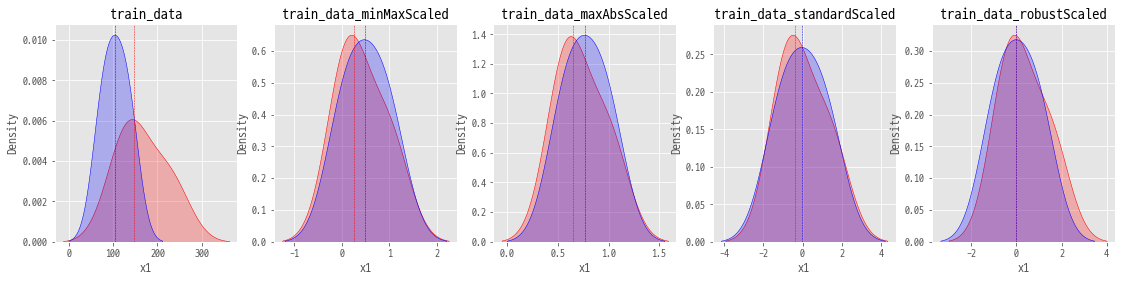

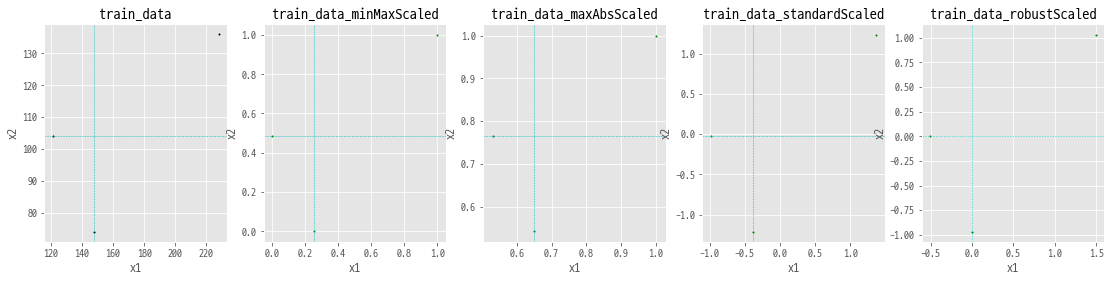

In [45]:
scale(train_data, scatter_show_YN=True, kdeplot_show_YN=True)